In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

ImageW = 1000
ImageH = 1000
RN = 32

def mul_bias(X, W):
    ids = tf.indices(list(X.shape[:-1]) + [W.shape[-2]])
    return tf.select(ids[-1] == X.shape[-1], 0.01, X[ids]) @ W

def GELU(x):
    return 0.5*x*(1.0+tf.tanh(0.7978845608*(x+0.044715*x*x*x)))

def leaky_relu(x):
    return tf.select(x > 0.0, x, 0.01*x)

class TextureEmbedder(tf.Module):
    def __init__(self, embedding_size = RN, embedding_channels = 16, channel_count = 3):
        super().__init__()
        self.embedding_size = embedding_size
        self.channel_count = channel_count
        self.embedding_channels = embedding_channels
        self.hidden_size = embedding_channels
        self.dequant_scale = tf.Parameter([embedding_channels], tf.float32, random_scale = 2.0)
        self.dequant_bias = tf.Parameter([embedding_channels], tf.float32, random_scale = 0.0)
        self.tex = tf.Parameter([embedding_size, embedding_size, embedding_channels], tf.float32, random_scale = 1.0)
        self.fc1 = tf.Parameter([embedding_channels, self.hidden_size], tf.float32) 
        self.fc2 = tf.Parameter([self.hidden_size+1, self.hidden_size], tf.float32)
        self.fc3 = tf.Parameter([self.hidden_size+1, channel_count], tf.float32)
        self.seed = tf.Parameter([1], tf.uint32, random_scale = 0, optimize = False)

    def random_quantize(self, X):
        r = self.rand(X.shape) - 0.5
        return tf.round(127.0*X + 1.0*r).pass_grad() / 127.0

    def sample(self, i, j, k):
        res = self.tex[i, j, k]
        res = tf.clamp(res, -1.0, 1.0)
        res = self.random_quantize(res)
        #res = tf.clamp(tf.round(127.0*self.tex[i, j, k]).pass_grad(), -127.0, 127.0) / 127.0
        return res

    def bilinear(self, x, y, ch):
        #offset each channel to avoid zeros in the gradients
        chidx = ch/4
        offset_x = tf.float(chidx%2) / 2.0
        offset_y = tf.float(chidx/2) / 2.0
        x, y = x+offset_x, y+offset_y
        xi, yi = tf.floor(x), tf.floor(y)
        xf, yf = x-xi, y-yi
        xi, yi = tf.int(xi), tf.int(yi)

        #fake cubic interpolation
        xf = tf.smoothstep(0.0, 1.0, xf)
        yf = tf.smoothstep(0.0, 1.0, yf)

        oxf, oyf = 1.0-xf, 1.0-yf
        interp_res = self.sample(xi, yi, ch)*oxf*oyf + self.sample(xi+1, yi, ch)*xf*oyf + self.sample(xi, yi+1, ch)*oxf*yf + self.sample(xi+1, yi+1, ch)*xf*yf
        return interp_res * self.dequant_scale[ch] + self.dequant_bias[ch]

   
    def forward(self, x, y):
        embed = self.bilinear(x, y, x.indices[-1])
        embed = GELU(mul_bias(embed, self.fc1))
        embed = GELU(mul_bias(embed, self.fc2))
        return (mul_bias(embed, self.fc3))

    def loss(self, X, Y):
        i, j = tf.indices([X.shape[0], self.embedding_channels])
        Yhat = self.forward(X[i, 0], X[i, 1])
        diff = Yhat - Y

        tex_reg = tf.mean(tf.mean(tf.mean(self.tex*self.tex)))

        return tf.mean(tf.mean(diff*diff)) + 0.001*tex_reg
    
    def rand_seed(self, shape, seed):
        indices = tf.indices(shape)
        element_index = 0
        for i in range(len(shape)):
            element_index = element_index * shape[i] + indices[i]
        return tf.pcgf(tf.uint(element_index) + seed)

    def rand(self, shape):
        self.seed = tf.pcg(self.seed)
        return self.rand_seed(shape, self.seed)

def NeuralEmbed():
    pos = tf.input([-1, 2], tf.float32)
    N = pos.shape[0]
    val = tf.input([N, 3], tf.float32)
    
    info = tf.input([-1], tf.float32)
    learning_rate = info[0]

    model = TextureEmbedder()
    opt = tf.optimizers.adam(model, learning_rate = learning_rate)
    #opt.set_clipping_type(tf.clipping.norm)
    opt.initialize_input()

    loss = opt.step(pos, val)

    #clamp the texture
    model.tex = tf.clamp(model.tex, -1.0, 1.0)

    params = opt.parameters()
    params.append(loss)
    return params

reconstruct = tf.compile(NeuralEmbed)

def RenderImage():
    model = TextureEmbedder()
    model.initialize_input()

    i, j, e = tf.indices([ImageH, ImageW, model.embedding_channels])
    x, y = tf.float(i*(model.embedding_size-1))/float(ImageH), tf.float(j*(model.embedding_size-1))/float(ImageW)
    x = tf.float(model.embedding_size-1) - x
    color = tf.abs(model.forward(x, y))

    return color

    xgrad = tf.sum(tf.grad(color, x))

    return tf.repeat(tf.unsqueeze(tf.abs(xgrad)), 3)

render = tf.compile(RenderImage)

TensorFrost module loaded!
NeuralEmbed:
  Kernel count: 40
  Intermediate buffers: 30
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 684
  IR Compile time: 100.431000 ms
  Codegen time: 14.376900 ms
  Host Compile time: 1545.133911 ms
  Shader Compile time: 233.164612 ms

RenderImage:
  Kernel count: 6
  Intermediate buffers: 5
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 522
  IR Compile time: 34.728600 ms
  Codegen time: 3.800500 ms
  Host Compile time: 1462.347412 ms
  Shader Compile time: 72.137100 ms



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


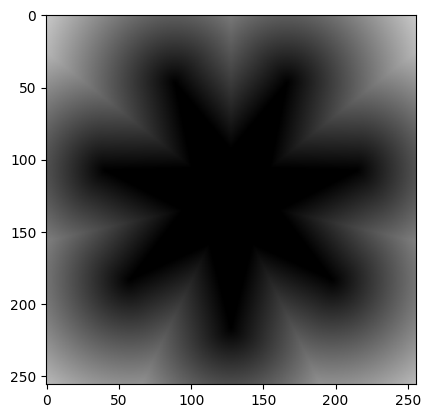

(256, 256, 3)


In [2]:
input_img = np.array(plt.imread("test.png"), dtype=np.float32)

input_img = input_img[:,:,:3] *input_img[:,:,3:4]

def numpy_star_sdf(size, r=0.7, n=7, w=0.5):
    def sdStar(p, r, n, w):
        m = n + w * (2.0 - n)
        an = np.pi / n
        en = np.pi / m
        racs = r * np.array([np.cos(an), np.sin(an)])
        ecs = np.array([np.cos(en), np.sin(en)])

        p[:, :, 0] = np.abs(p[:, :, 0])

        bn = np.mod(np.arctan2(p[:, :, 0], p[:, :, 1]), 2.0 * an) - an
        p_len = np.sqrt(np.sum(p**2, axis=2))
        p = np.stack([p_len * np.cos(bn), p_len * np.abs(np.sin(bn))], axis=2)

        p -= racs
        dot_product = np.sum(p * ecs, axis=2)
        clamp_value = np.clip(-dot_product, 0.0, racs[1] / ecs[1])
        p += ecs * clamp_value[:, :, np.newaxis]

        return np.sqrt(np.sum(p**2, axis=2)) * np.sign(p[:, :, 0])

    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    p = np.stack([X, Y], axis=2)

    return sdStar(p, r, n, w)

# Example usage
size = 256
sdf_values = numpy_star_sdf(size)

input_img = np.repeat(sdf_values[..., np.newaxis], 3, axis=2)

plt.imshow(input_img)
plt.show()
print(input_img.shape)


In [3]:
#get list of pixels
N = input_img.shape[0]*input_img.shape[1]
pos = np.zeros((N, 2))
vals = np.zeros((N, 3))
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        pos[i*input_img.shape[1]+j] = [i/input_img.shape[0], j/input_img.shape[1]]
        vals[i*input_img.shape[1]+j] = input_img[i, j]

pos *= (np.array([RN - 1, RN - 1]))

#randomize the order
order = np.arange(N)
np.random.shuffle(order)
pos = pos[order]
vals = vals[order]

In [4]:
model = TextureEmbedder()
opt = tf.optimizers.adam(model)
opt.initialize_parameters()

In [5]:
import time

tf.window.show(ImageW, ImageH, "reconstruction")

prev_time = time.time()
smooth_delta_time = 0.0
do_optimization = False

lr = 0.002
normalize = True

batch_size = 256
iters_per_frame = 200
loss_hist = []
loss_val = 0.0
freeze_weights = False
freeze_tex = False

iteration = 0

lrs = [0.002, 0.001, 0.0005, 0.0001]
steps = [0, 50000, 100000, 200000]
def schedule(step): #interpolate between steps
    for i in range(len(steps)-1):
        if step >= steps[i] and step < steps[i+1]:
            return lrs[i] + (lrs[i+1] - lrs[i])*(step - steps[i])/(steps[i+1] - steps[i])
    return lrs[-1]

while not tf.window.should_close():
    cur_time = time.time()

    delta_time = cur_time - prev_time
    smooth_delta_time = 0.9 * smooth_delta_time + 0.1 * delta_time

    if do_optimization:
        lr = schedule(iteration)
        params = [0.0 if freeze_tex else lr, 0.0 if freeze_weights else lr]
        for _ in range(iters_per_frame):
            rand_offset = np.random.randint(N - batch_size)
            pos_tf = tf.tensor(pos[rand_offset:rand_offset+batch_size])
            vals_tf = tf.tensor(vals[rand_offset:rand_offset+batch_size])
            output = reconstruct(pos_tf, vals_tf, params, opt)
            loss = output[-1]
            opt.update_parameters(output[:-1])
            iteration += 1
        loss_val = loss.numpy
        loss_hist.append(loss_val)
        
    normalize = False

    tf.window.render_frame(render(model))
    tf.imgui.text("Frame time: %.3f ms" % (1000.0 * smooth_delta_time))
    tf.imgui.text("FPS: %.1f" % (1.0 / (smooth_delta_time + 1e-5)))
    do_optimization = tf.imgui.checkbox("Optimize", do_optimization)
    avg_loss = np.mean(loss_hist[-100:])
    tf.imgui.text("Loss: %.5f" % np.log10(avg_loss))
    tf.imgui.text("Iteration: %d" % iteration)
    lr = tf.imgui.slider("Learning rate", lr, 0.0, 0.1)
    iters_per_frame = tf.imgui.slider("Iterations per frame", iters_per_frame, 1, 200)
    batch_size = tf.imgui.slider("Batch size", batch_size, 64, 10000)
    freeze_weights = tf.imgui.checkbox("Freeze weights", freeze_weights)
    freeze_tex = tf.imgui.checkbox("Freeze texture", freeze_tex)
    normalize = tf.imgui.checkbox("Normalize", normalize)

    if iteration == 400000:
        avg_loss = np.mean(loss_hist[-100:])
        print("Average loss: %.5f" % avg_loss)
    
    prev_time = cur_time

print("Final loss: %.5f" % loss_val)

c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\micha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Final loss: 0.00002


C:\Users\micha\AppData\Local\Temp\ipykernel_41600\2901534768.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Final loss: %.5f" % loss_val)


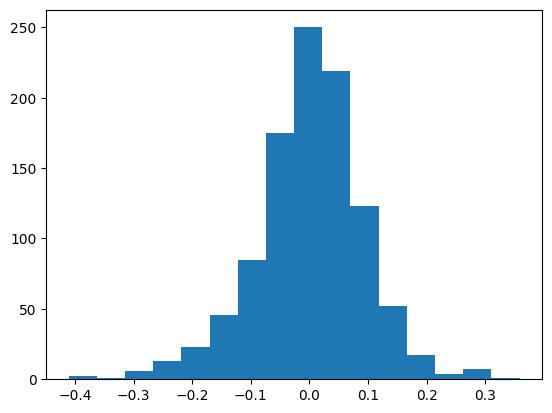

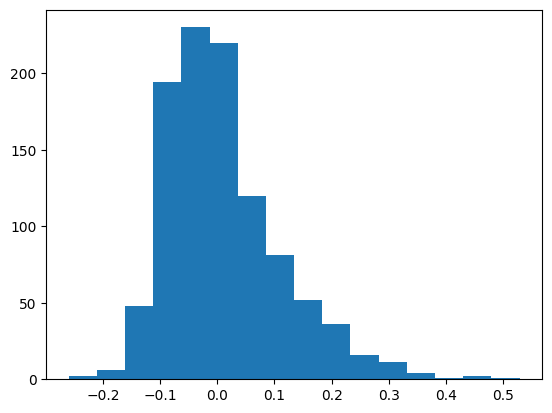

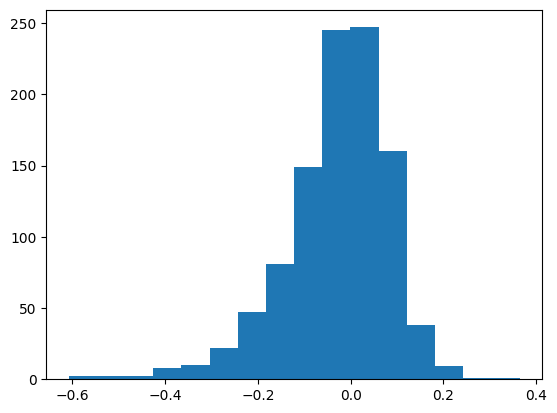

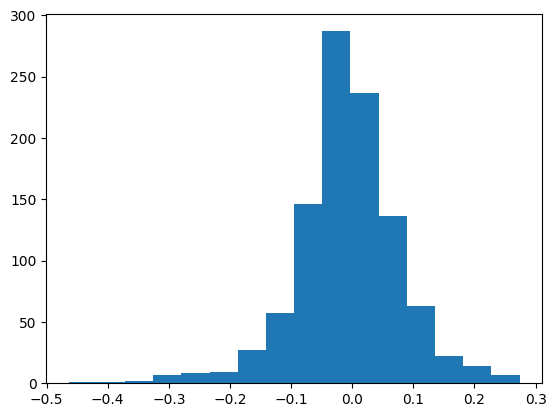

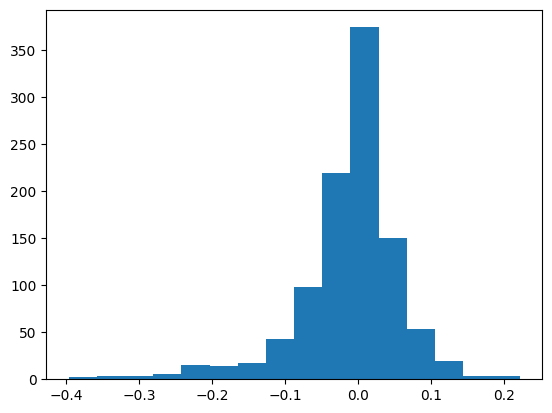

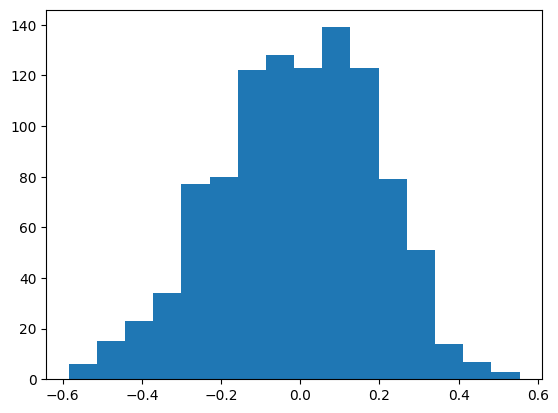

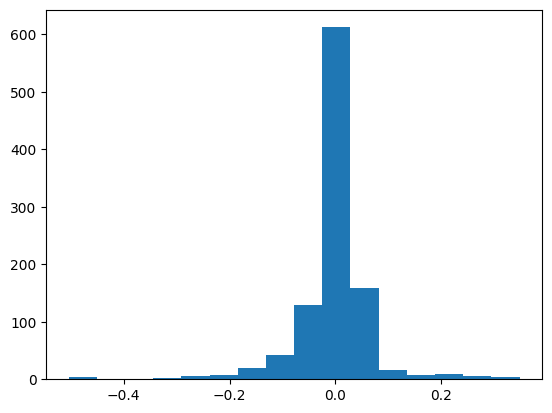

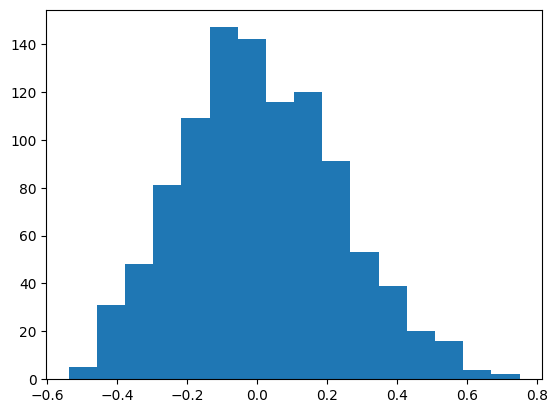

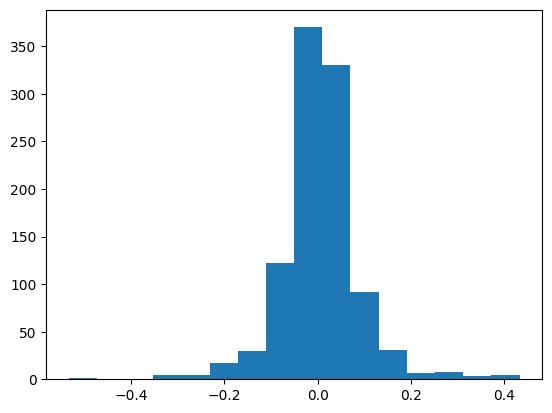

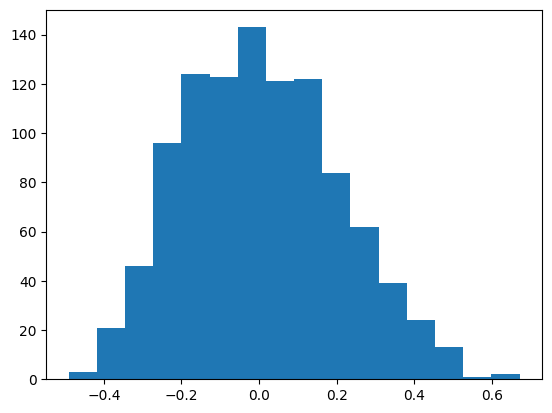

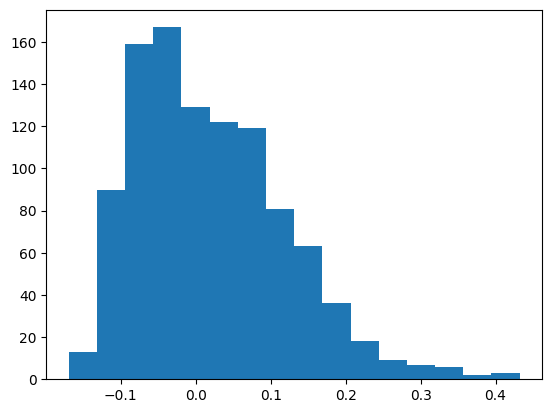

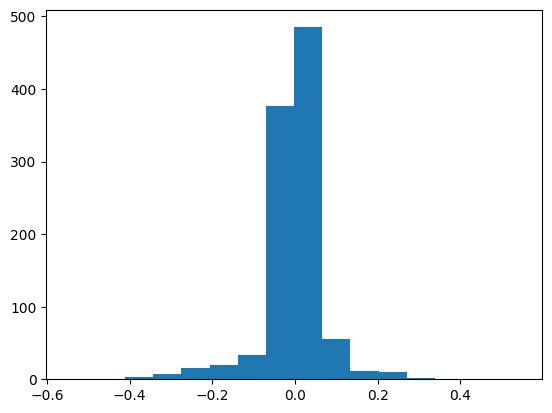

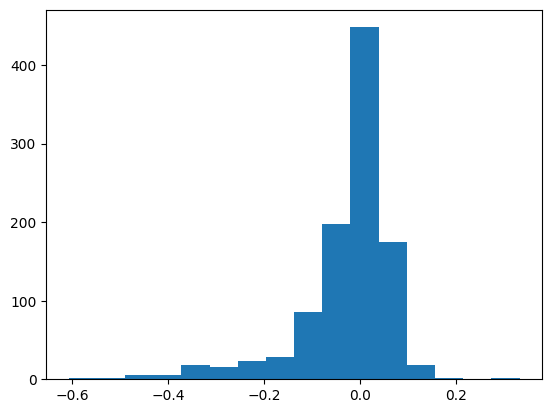

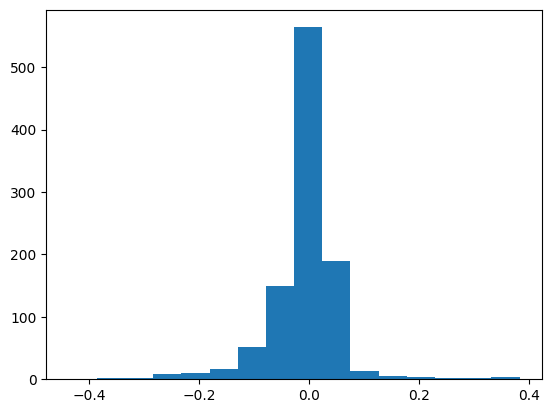

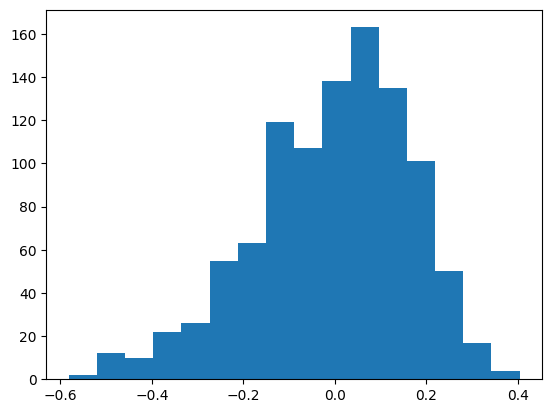

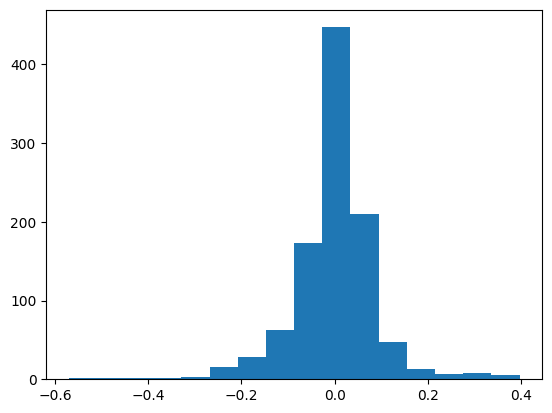

In [6]:
embedding = model.tex.numpy
#plot histogram for each channel
for i in range(embedding.shape[-1]):
    plt.hist(embedding[:,:,i].flatten(), bins=16)
    plt.show()
